# Part 1: Importing the Dataset to DataFrame

In [6]:
import pandas as pd
import os

# Define a function to read the content of a file
def readFile(filePath):
    with open(filePath, 'r', encoding='utf-8') as file:
        return file.read()

# Define a function to create a DataFrame from a folder of text files with a specified label
def createDataframe(folderPath, label):
    files = os.listdir(folderPath)                  # List all files in the given folder
    data = {'text': [], 'label': []}                # Initialize a dictionary to store data
    
    # Loop through each file in the folder
    for file in files:
        filePath = os.path.join(folderPath, file)
        content = readFile(filePath)                # Read the content of the file
        
        # Append content and label to the data dictionary
        data['text'].append(content)
        data['label'].append(label)
    
    return pd.DataFrame(data)                       # Create a DataFrame from the data dictionary

# Define folder paths for positive and negative reviews
posFolderPath = os.path.join('./', 'txt_sentoken', 'pos')
negFolderPath = os.path.join('./', 'txt_sentoken', 'neg')

# Create DataFrames for positive and negative reviews
pos_df = createDataframe(posFolderPath, 'pos')
neg_df = createDataframe(negFolderPath, 'neg')

# Combine positive and negative DataFrames into one
combined_df = pd.concat([pos_df, neg_df], ignore_index=True)

combined_df

,text,label
0,films adapted from comic books have had plenty...,pos
1,every now and then a movie comes along from a ...,pos
2,you've got mail works alot better than it dese...,pos
3,""" jaws "" is a rare film that grabs your atten...",pos
4,moviemaking is a lot like being the general ma...,pos
...,...,...
1995,"if anything , "" stigmata "" should be taken as ...",neg
1996,"john boorman's "" zardoz "" is a goofy cinematic...",neg
1997,the kids in the hall are an acquired taste . \...,neg
1998,there was a time when john carpenter was a gre...,neg


# Part 2: Tokenization

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

stopWords = ['would', 'characters', 'like', 'character', 'time', 'story', 'one', 'film', 'movie', 'above', 'here', 'too', 'ours', 'same', 'no', 'some', 'whom', 'over', 'does', 'the', 'through', 'am', 'those', 'at', 'having', 'she', 'again', 'which', 'until', 'while', 'don', 'to', 'this', 'other', 'after', 'my', 'each', 'such', 'them', 'it', 'should', 'her', 'herself', 'how', 'has', 'any', 's', 'then', 'can', 'but', 'there', 'they', 'most', 'our', 'him', 'these', 'himself', 'yourselves', 'itself', 'of', 'are', 'he', 'you', 'only', 'because', 'from', 'had', 'who', 'own', 'if', 'yours', 'during', 'below', 'his', 'nor', 'themselves', 'between', 'more', 'when', 'where', 'being', 'few', 'with', 'be', 'hers', 'for', 'out', 'doing', 'into', 'ourselves', 'down', 'do', 'off', 'their', 't', 'all', 'that', 'will', 'about', 'been', 'as', 'before', 'is', 'now', 'we', 'or', 'by', 'than', 'an', 'and', 'once', 'just', 'up', 'against', 'not', 'on', 'its', 'very', 'did', 'yourself', 'both', 'so', 'your', 'were', 'i', 'in', 'a', 'further', 'was', 'me', 'myself', 'what', 'theirs', 'under', 'have', 'why']

# Define a function to get the most common words in a list of texts
def getMostCommonWords(texts, n=10):
    vectorizer = CountVectorizer(stop_words = stopWords)                                # Create a CountVectorizer with custom stop words
    X = vectorizer.fit_transform(texts)                                                 # Transform the input texts into a document-term matrix
    words = vectorizer.get_feature_names_out()                                          # Get the feature names (words)
    wordCounts = X.sum(axis=0).A1                                                       # Calculate the sum of word occurrences across all documents
    wordFrequency = dict(zip(words, wordCounts))                                        # Create a dictionary of word frequencies
    sortedWordFreq = sorted(wordFrequency.items(), key=lambda x: x[1], reverse=True)    # Sort the word frequencies in descending order
    return sortedWordFreq[:n]                                                           # Return the top 'n' most common words

# Get the most common words in positive and negative reviews
posWords = getMostCommonWords(pos_df['text'])
negWords = getMostCommonWords(neg_df['text'])

# Create DataFrames for the most common words in positive and negative reviews
posDataFrame = pd.DataFrame(posWords, columns=['Word', 'Frequency'])
negDataFrame = pd.DataFrame(negWords, columns=['Word', 'Frequency'])

# Print the most common words in positive and negative reviews
print("Most common words in positive reviews:")
print(posDataFrame)

print("\nMost common words in negative reviews:")
print(negDataFrame)


Most common words in positive reviews:
    Word  Frequency
0   good       1248
1   also       1200
2   even       1179
3   well       1123
4   life       1057
5   much       1038
6  first       1004
7    two        999
8    see        965
9    way        929

Most common words in negative reviews:
    Word  Frequency
0   even       1386
1   good       1163
2    get       1052
3    bad       1034
4   much       1011
5   plot        917
6    two        912
7   make        851
8  first        832
9  could        791


# Subpart 2.5: Visualization of Most Common Words

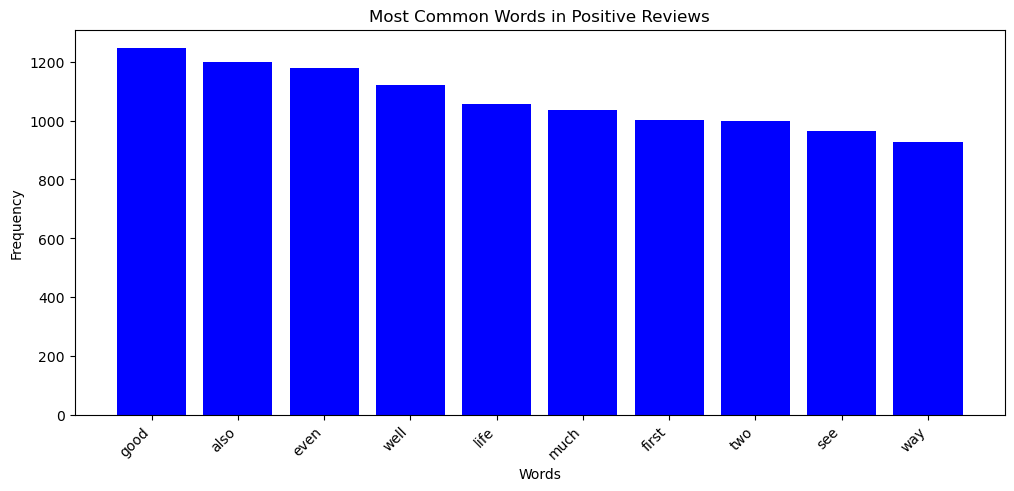

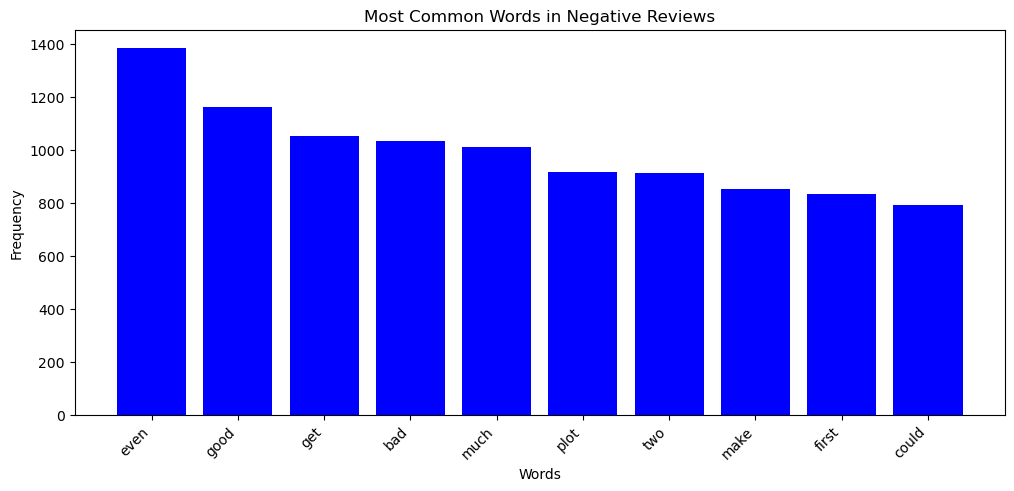

In [8]:
import matplotlib.pyplot as plt

def plotMostCommonWords(data_frame, title):
    plt.figure(figsize=(12, 5))
    plt.bar(data_frame['Word'], data_frame['Frequency'], color='blue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Visualize most common words in positive reviews
plotMostCommonWords(posDataFrame, 'Most Common Words in Positive Reviews')
plotMostCommonWords(negDataFrame, 'Most Common Words in Negative Reviews')


# Part 3: Naive Bayes Algorithm for Sentiment Analysis without Library

In [9]:
import numpy as np
from numpy.random import shuffle, seed

class NaiveBayesClassifier:
    # Initialize class probabilities and word probabilities dictionaries
    def __init__(self):
        self.classProbs = {}
        self.wordProbs = {}

    # Calculate class probabilities based on the input labels
    def calcClassProb(self, labels):
        uniqueLabels, counts = np.unique(labels, return_counts=True)
        totalSamples = len(labels)

        for label, count in zip(uniqueLabels, counts):
            self.classProbs[label] = count / totalSamples

    # Calculate word probabilities for each class based on the input documents and labels
    def calcWordProb(self, documents, labels):
        combinedData = list(zip(documents, labels))
        for label in set(labels):
            labelData = [data[0] for data in combinedData if data[1] == label]
            labelWordCounts = {}
            totalWords = 0

            for document in labelData:
                words = document.split()
                totalWords += len(words)
                for word in words:
                    if word in labelWordCounts:
                        labelWordCounts[word] += 1
                    else:
                        labelWordCounts[word] = 1
            wordProbs = {word: (count) / totalWords for word, count in labelWordCounts.items()}
            self.wordProbs[label] = wordProbs

    # Train the Naive Bayes Classifier by calculating class and word probabilities
    def train(self, documents, labels):
        self.calcClassProb(labels)
        self.calcWordProb(documents, labels)

    # Predict the class of a given document
    def predict(self, document):
        words = document.split()
        maxProb = float('-infinity')
        predictedClass = None

        # Calculate the probability of each class for the given document
        for label, classProb in self.classProbs.items():
            wordProb = self.wordProbs[label]
            documentProb = np.log(classProb)

            # Calculate the document probability based on word probabilities
            for word in words:
                if word in wordProb:
                    documentProb += np.log(wordProb[word])

            # Update the predicted class if the current probability is higher
            if documentProb > maxProb:
                maxProb = documentProb
                predictedClass = label
        return predictedClass
    
    # Evaluate the classifier's performance using test documents and labels
    def evaluate(self, testDocuments, testLabels):
        predictions = [self.predict(document) for document in testDocuments]
        truePositive, falsePositive, trueNegative, falseNegative = 0, 0, 0, 0

        # Calculate metrics such as accuracy, precision, recall, and F1 score
        for predictedLabel, trueLabel in zip(predictions, testLabels):
            if predictedLabel == trueLabel and trueLabel == 'pos':
                truePositive += 1
            elif predictedLabel == trueLabel and trueLabel == 'neg':
                trueNegative += 1
            elif predictedLabel != trueLabel and trueLabel == 'pos':
                falseNegative += 1
            elif predictedLabel != trueLabel and trueLabel == 'neg':
                falsePositive += 1

        accuracy = (truePositive + trueNegative) / len(testLabels)
        precision = truePositive / (truePositive + falsePositive) if (truePositive + falsePositive) != 0 else 0
        recall = truePositive / (truePositive + falseNegative) if (truePositive + falseNegative) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        return accuracy, precision, recall, f1

# Define a function for training and test data split
def trainTestSplit(data, labels, testSize, randomState=None):
    if randomState:
        seed(randomState)
    
    indices = np.arange(len(data))
    shuffle(indices)

    splitIndex = int((1 - testSize) * len(data))
    trainIndices, testIndices = indices[:splitIndex], indices[splitIndex:]

    trainData, testData = [data[i] for i in trainIndices], [data[i] for i in testIndices]
    trainLabels, testLabels = [labels[i] for i in trainIndices], [labels[i] for i in testIndices]

    return trainData, testData, trainLabels, testLabels

# Prepare data for training and testing
documents = combined_df['text'].tolist()
labels = combined_df['label'].tolist()

# Split the data into training and testing sets
trainDocuments, testDocuments, trainLabels, testLabels = trainTestSplit(documents, labels, testSize=0.25, randomState=40)

# Create an instance of the NaiveBayesClassifier class
NaiveBayesClassifierInstance = NaiveBayesClassifier()
# Train the classifier using the training data
NaiveBayesClassifierInstance.train(trainDocuments, trainLabels)

# Perform predictions on sample test documents
sampleTest = ["I didn't like the movie, total trash", "This is really nice movie, I enjoyed it"]
for document in sampleTest:
    prediction = NaiveBayesClassifierInstance.predict(document)
    print(f"Prediction for '{document}':    {prediction}")

# Evaluate the classifier's performance using the test data
accuracy, precision, recall, f1 = NaiveBayesClassifierInstance.evaluate(testDocuments, testLabels)
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Prediction for 'I didn't like the movie, total trash':    neg
Prediction for 'This is really nice movie, I enjoyed it':    pos

Evaluation Metrics:
Accuracy: 0.41
Precision: 0.34355828220858897
Recall: 0.22950819672131148
F1 Score: 0.2751842751842752


# Part 4: Naive Bayes Algorithm for Sentiment Analysis with Library (sklearn)

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Split the data into training and testing sets
xTrain, xTest, yTrain, yTest = train_test_split(combined_df['text'], combined_df['label'], test_size=0.25, random_state=40)

# Create a CountVectorizer with custom stop words
vectorizer = CountVectorizer(stop_words=stopWords)

# Vectorize the training and testing data
xTrainVectorized = vectorizer.fit_transform(xTrain)
xTestVectorized = vectorizer.transform(xTest)

classifier = MultinomialNB()                        # Initialize a Multinomial Naive Bayes classifier
classifier.fit(xTrainVectorized, yTrain)            # Train the classifier on the vectorized training data
yPrediction = classifier.predict(xTestVectorized)   # Make predictions on the vectorized testing data

# Calculate accuracy, confusion matrix, and classification report
accuracy = accuracy_score(yTest, yPrediction)
confMatrix = confusion_matrix(yTest, yPrediction)
classificationReport = classification_report(yTest, yPrediction)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(confMatrix)
print("\nClassification Report:")
print(classificationReport)
print("\n")

# Perform custom predictions on some sample input
customInput = ["I didn't like the movie, total trash", "This is really nice movie, I enjoyed it"]
customPredictions = classifier.predict(vectorizer.transform(customInput))

# Display custom predictions
for text, prediction in zip(customInput, customPredictions):
    print(f"Text: {text}\nPrediction: {prediction}\n")

Accuracy: 0.814

Confusion Matrix:
[[214  47]
 [ 46 193]]

Classification Report:
              precision    recall  f1-score   support

         neg       0.82      0.82      0.82       261
         pos       0.80      0.81      0.81       239

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



Text: I didn't like the movie, total trash
Prediction: neg

Text: This is really nice movie, I enjoyed it
Prediction: pos

